# IMPORT

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Посмотрим имеющиеся датасеты на предмет того, сколько строк и столбцов в них, сколько пропусков и какие тип данных.  
Так же сравним, чтобы одинаковые признаки имели одинаковый тип данных.  

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


В итоговом датасете видим:  
- 50 тыс строк с индексами от 0 до 49999
- 11 столбцов
- 4 столбца с числовыми значениями, 7 с текстовыми

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5) # посмотрим случайные строки для лучшего понимания, как выглядит датасет

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
36223,id_3003,Barcelona,['Chinese'],3004.0,$,36.0,"[['Good food for the price, no skimping, they....",/Restaurant_Review-g187497-d7917267-Reviews-Pa...,d7917267,1,4.0
33707,id_258,Copenhagen,"['Spanish', 'Wine Bar', 'European']",259.0,$$ - $$$,126.0,"[['Good Wine, Friendly Atmosphere', 'Great con...",/Restaurant_Review-g189541-d7078270-Reviews-Vi...,d7078270,1,4.0
9728,id_9728,Berlin,NaN,3273.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187323-d9768082-Reviews-Bu...,d9768082,0,0.0
2525,id_2525,Madrid,"['Bar', 'Cafe', 'Spanish', 'Pub', 'Fusion']",3776.0,$$ - $$$,5.0,"[[], []]",/Restaurant_Review-g187514-d13160174-Reviews-S...,d13160174,0,0.0
19861,id_13203,Paris,NaN,13205.0,NaN,43.0,"[['Top service and top food', 'Fresh'], ['04/1...",/Restaurant_Review-g187147-d5808791-Reviews-GR...,d5808791,1,3.5


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Изучаем подробно каждый признак

In [14]:
def values_information(col):
    '''Ф-ция принимает на вход название столбца, а возвращает 
    инфу о пропусках, уникальных значениях и о типе данных'''
    
    skip = pd.isna(data[col]).sum()
    uniq = data[col].nunique()
    d_types = data[col].dtypes
    
    print(col)
    print('{} - пропусков'.format(skip))
    print('{} - уникальных значений'.format(uniq))
    print('{} - тип данных'.format(d_types))

## 1. Restaurant_id

In [15]:
values_information('Restaurant_id')

Restaurant_id
0 - пропусков
13094 - уникальных значений
object - тип данных


In [16]:
data['Restaurant_id'].value_counts()

id_633      19
id_871      19
id_227      19
id_436      19
id_534      18
            ..
id_14449     1
id_11542     1
id_5681      1
id_11637     1
id_8275      1
Name: Restaurant_id, Length: 13094, dtype: int64

Сразу видим интересный момент. Есть много ресторанов с одинаковыми **Restaurant_id**.  
Попробуем разобраться дальше, что это может означать

## 2. City

In [17]:
values_information('City')

City
0 - пропусков
31 - уникальных значений
object - тип данных


## 3. Cuisine Style

In [18]:
values_information('Cuisine Style')

Cuisine Style
11590 - пропусков
10731 - уникальных значений
object - тип данных


Много пропусков. Дальше заполним их отдельным значением и посмотрим на работу модели. Возможо в пропусках есть закономерность

## 4. Ranking

In [19]:
values_information('Ranking')

Ranking
0 - пропусков
12975 - уникальных значений
float64 - тип данных


### Изучим распределение числового признака


Text(0.5, 0, 'Ranking')

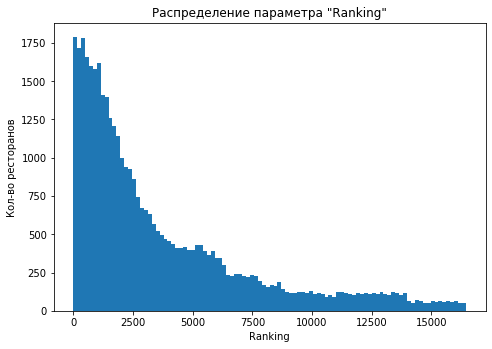

In [20]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df_train['Ranking'], bins=100)
axes.set_title('Распределение параметра "Ranking"')
axes.set_ylabel('Кол-во ресторанов')
axes.set_xlabel('Ranking')

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

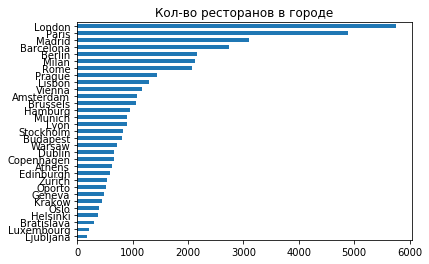

In [21]:
df_train['City'].value_counts(ascending=True).plot(kind='barh', title='Кол-во ресторанов в городе')

Посмотрим, как изменится распределение в большом городе:

Text(0.5, 0, 'Ranking')

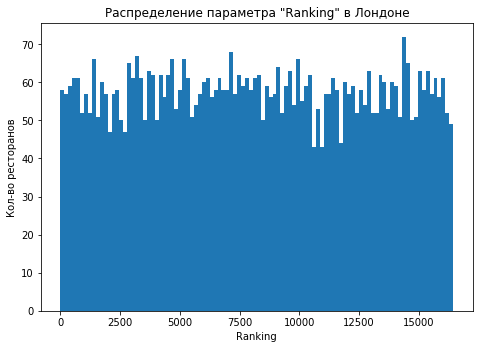

In [22]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df_train['Ranking'][df_train['City'] =='London'], bins=100)
axes.set_title('Распределение параметра "Ranking" в Лондоне')
axes.set_ylabel('Кол-во ресторанов')
axes.set_xlabel('Ranking')

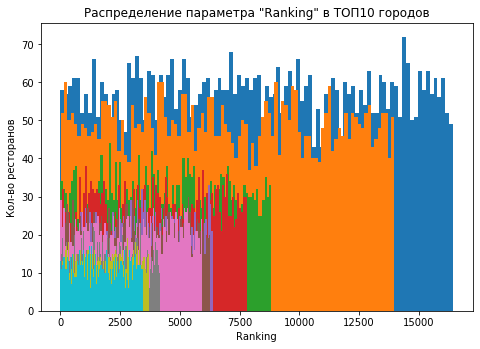

In [23]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.set_title('Распределение параметра "Ranking" в ТОП10 городов')
axes.set_ylabel('Кол-во ресторанов')
axes.set_xlabel('Ranking')


for x in (df_train['City'].value_counts())[0:10].index:
    axes.hist(df_train['Ranking'][df_train['City'] == x], bins=100)

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Нужно создать признак который нормализует **"Ranking"**. Для этого **"Ranking"** поделим на **кол-во ресторанов в городе**

## 5. Price Range

In [24]:
values_information('Price Range')

Price Range
17361 - пропусков
3 - уникальных значений
object - тип данных


In [25]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

>- Этот признак можно поменять на числовой, т.к. чем выше значение, тем выше ценовой сегмент ресторана
>- Очень много ресторанов в среднем сегменте. Можно Пропуски заполнить им

## 6. Number of Reviews

In [26]:
values_information('Number of Reviews')

Number of Reviews
3200 - пропусков
1573 - уникальных значений
float64 - тип данных


Посмотрим распределение признака 'Number of Reviews'  
Сколько ресторанов (по оси Y) имеют какое кол-во оценок (По оси X)

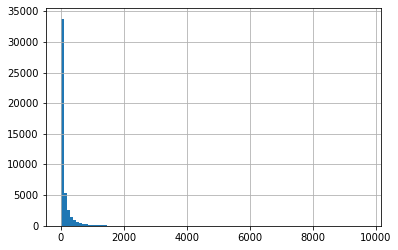

In [27]:
data['Number of Reviews'].hist(bins=100)

## 7. Reviews

In [28]:
values_information('Reviews')

Reviews
2 - пропусков
41857 - уникальных значений
object - тип данных


Пропуски Можно смело заполнить **"[[], []]"** - такие значения уже есть  
Сразу же это и сделаем

In [29]:
data['Reviews'].fillna("[[], []]", inplace=True)

Так же мы тут видим, что строки со значением **"[[], []]"** имеют много пропусков в столбце кол-ва отзывов.  
Т.о. делаем выводы, что тут кол-во отзывов скорее всего = 0

In [30]:
data[(data['Reviews'] == "[[], []]") & (pd.isna(data['Number of Reviews']))].head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
7,id_7,Budapest,NaN,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0
25,id_25,Madrid,NaN,5828.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187514-d13202032-Reviews-W...,d13202032,0,0.0
53,id_53,Prague,NaN,2095.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274707-d7124128-Reviews-Ch...,d7124128,0,0.0
81,id_81,Barcelona,"['Peruvian', 'South American']",4325.0,$$ - $$$,NaN,"[[], []]",/Restaurant_Review-g187497-d10088997-Reviews-N...,d10088997,0,0.0
114,id_114,Lyon,NaN,2001.0,NaN,NaN,"[[], []]",/Restaurant_Review-g1166685-d12644341-Reviews-...,d12644341,0,0.0


Так-же если мы посмотрим остальные пропуски по кол-ву отзывов, то там в каждом случае только 1 отзыв.

In [31]:
data[(data['Reviews'] != "[[], []]") & (pd.isna(data['Number of Reviews']))].sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
37705,id_367,Bratislava,NaN,368.0,NaN,NaN,"[['Place, where people love, what they do'], [...",/Restaurant_Review-g274924-d12511629-Reviews-P...,d12511629,1,5.0
10540,id_3052,Prague,NaN,3059.0,NaN,NaN,"[['Good fast food'], ['02/25/2017']]",/Restaurant_Review-g274707-d12172734-Reviews-C...,d12172734,1,4.0
74,id_74,Prague,"['Cafe', 'European', 'Czech']",2052.0,$,NaN,"[[""Nova' Doba""], ['01/26/2017']]",/Restaurant_Review-g274707-d12032989-Reviews-C...,d12032989,0,0.0
41721,id_4142,Prague,NaN,4162.0,NaN,NaN,"[['Horrible chef'], ['12/18/2017']]",/Restaurant_Review-g274707-d11538644-Reviews-H...,d11538644,1,1.0
19367,id_3104,Prague,NaN,3111.0,NaN,NaN,"[['Good cakes'], ['02/09/2015']]",/Restaurant_Review-g274707-d7124051-Reviews-Cu...,d7124051,1,4.0


Следовательно после анализа параметров "отзывы" и "кол-во" отзывов, мы имеем представление, чем заполнять пропуски параметра "Кол-во отзывов"

## 8. URL_TA

In [32]:
values_information('URL_TA')

URL_TA
0 - пропусков
49963 - уникальных значений
object - тип данных


Найдем значения, которые дублируются

In [33]:
data['URL_TA'].value_counts()

/Restaurant_Review-g187514-d3685055-Reviews-Shukran-Madrid.html                                         2
/Restaurant_Review-g187514-d2477531-Reviews-Haya_19-Madrid.html                                         2
/Restaurant_Review-g187514-d2669414-Reviews-Vips-Madrid.html                                            2
/Restaurant_Review-g187514-d11698990-Reviews-Verdello_Restaurante-Madrid.html                           2
/Restaurant_Review-g187514-d10047799-Reviews-Entrepuntos-Madrid.html                                    2
                                                                                                       ..
/Restaurant_Review-g190454-d13197046-Reviews-Eatalia-Vienna.html                                        1
/Restaurant_Review-g187514-d12214046-Reviews-Tripea-Madrid.html                                         1
/Restaurant_Review-g186338-d4925037-Reviews-Shanghai_Surprise-London_England.html                       1
/Restaurant_Review-g187147-d2392323-Reviews-Ch

In [34]:
doble_urlta = data['URL_TA'].value_counts()

In [35]:
doble_urlta[doble_urlta > 1].index

Index(['/Restaurant_Review-g187514-d3685055-Reviews-Shukran-Madrid.html',
       '/Restaurant_Review-g187514-d2477531-Reviews-Haya_19-Madrid.html',
       '/Restaurant_Review-g187514-d2669414-Reviews-Vips-Madrid.html',
       '/Restaurant_Review-g187514-d11698990-Reviews-Verdello_Restaurante-Madrid.html',
       '/Restaurant_Review-g187514-d10047799-Reviews-Entrepuntos-Madrid.html',
       '/Restaurant_Review-g187514-d3647024-Reviews-La_Zamorana-Madrid.html',
       '/Restaurant_Review-g187514-d5617412-Reviews-Green_Marta_Iii-Madrid.html',
       '/Restaurant_Review-g187514-d13002276-Reviews-Delish_Vegan_Doughnuts-Madrid.html',
       '/Restaurant_Review-g274856-d10316215-Reviews-Basico_Pizza-Warsaw_Mazovia_Province_Central_Poland.html',
       '/Restaurant_Review-g187514-d987900-Reviews-Compostela_Restaurante-Madrid.html',
       '/Restaurant_Review-g187514-d10440367-Reviews-Banyui_Thai_Restaurant-Madrid.html',
       '/Restaurant_Review-g187514-d1315077-Reviews-El_Pimiento_Verde-Madr

Первое, что бросается в глаза, так это с структуре ссылке повторяющийся эелемент вида **g187514**
Пока в ручном режиме сформируем срезы, которые содержат дублирующиеся значения и разные **g_____** в ссылке

In [36]:
data[data['URL_TA'] == '/Restaurant_Review-g187514-d11674463-Reviews-Beerhouse-Madrid.html']

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
14732,id_3804,Madrid,"['American', 'German', 'European', 'Central Eu...",3806.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463,1,4.0
21583,id_3810,Madrid,"['American', 'German', 'European', 'Central Eu...",3812.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463,1,4.0


In [37]:
data[data['URL_TA'] == '/Restaurant_Review-g187514-d3161682-Reviews-Cerveceria_La_Surena-Madrid.html']

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
35251,id_3575,Madrid,"['Spanish', 'Bar']",3577.0,$,217.0,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682,1,3.5
49847,id_3709,Madrid,"['Spanish', 'Bar']",3711.0,$,217.0,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682,1,3.5


In [38]:
data[data['URL_TA'] == '/Restaurant_Review-g274856-d3396817-Reviews-Restauracja_Olive_Garden-Warsaw_Mazovia_Province_Central_Poland.html']

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
4323,id_4323,Warsaw,"['Mediterranean', 'Middle Eastern', 'Italian',...",1981.0,$$ - $$$,16.0,"[['Good restaurant for one meal.', 'Olive Gard...",/Restaurant_Review-g274856-d3396817-Reviews-Re...,d3396817,0,0.0
15544,id_1980,Warsaw,"['Mediterranean', 'Middle Eastern', 'Italian',...",1981.0,$$ - $$$,16.0,"[['Good restaurant for one meal.', 'Olive Gard...",/Restaurant_Review-g274856-d3396817-Reviews-Re...,d3396817,1,4.0


In [39]:
data[data['URL_TA'] == '/Restaurant_Review-g274856-d10316215-Reviews-Basico_Pizza-Warsaw_Mazovia_Province_Central_Poland.html']

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
118,id_118,Warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,0,0.0
36920,id_1800,Warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,1,3.5


Очень интересно получается. Похоже, что это один и тот же ресторан, только, например, распооженный на разных улицах.
Но почему тогда разные Restaurant_id ? Ведь есть рестораны с одинаковыми Restaurant_id

### Посмотрим поближе на **g_____** в линке
Сделаем отдельный признак и изучим его

In [40]:
data['g_link'] = data['URL_TA'].apply(lambda x: x[19:26])

In [41]:
data['g_link'].value_counts()

g186338    7193
g187147    6108
g187514    3813
g187497    3395
g187323    2705
           ... 
g950783       2
g950782       2
g691944       1
g328492       1
g143960       1
Name: g_link, Length: 70, dtype: int64

Сколько не смотрел, не смог понять, что за признак.  
Как правило каждое значение соответствует отдельному городу. Но городов 31, а значений 70.  
Возможно модель МЛ лучше разберется ;)

## 9. ID_TA

In [42]:
values_information('ID_TA')

ID_TA
0 - пропусков
49963 - уникальных значений
object - тип данных


In [43]:
data['ID_TA'].value_counts()

d10047799    2
d8753348     2
d7827387     2
d5617412     2
d3161682     2
            ..
d1057679     1
d8802637     1
d1163117     1
d816637      1
d10815566    1
Name: ID_TA, Length: 49963, dtype: int64

Собственно тут мы уже понимаем, откуда дубли

## 10. Rating

In [44]:
values_information('Rating')

Rating
0 - пропусков
10 - уникальных значений
float64 - тип данных


In [45]:
data['Rating'].value_counts()

4.0    13692
4.5    10929
0.0    10000
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64

### Посмотрим распределение целевой переменной

А именно посмотрим каких оценок больше всего, а каких меньше

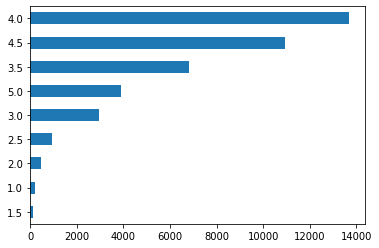

In [46]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака Ranking

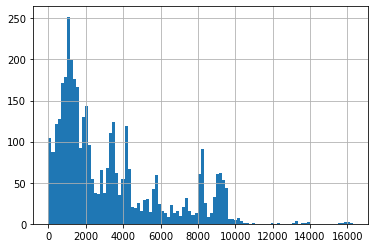

In [47]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

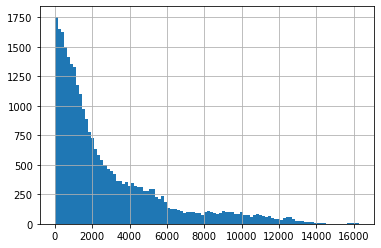

In [48]:
df_train['Ranking'][df_train['Rating'] >= 4].hist(bins=100)

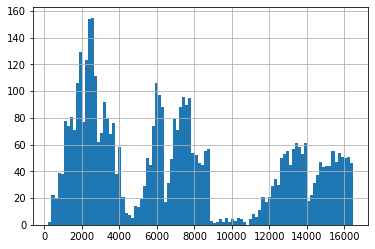

In [49]:
df_train['Ranking'][df_train['Rating'] <= 3].hist(bins=100)

Интересное наблюдение. Получается ресторан с высоким рейтингом может быть в локальном рейтинге относительно других ресторанов в самом конце.  
Стоит посмотреть на этот признак еще позже, когда нормализуем **Ranking**

------------

# ОБРАБОТКА NaN

Для начала мы создадим отдельный признка, где пометим какие строки имели пропуски  
Вот с какими признаками работаем:
- Cuisine Style
- Price Range
- Number of Reviews

In [50]:
data['Price RangeNAN'] = pd.isna(data['Price Range']).astype('uint8')

Price Range
--

Для удобства мы сделаем этот признак цифрами.  
Так как это признак цен в ресторане, то это будет корректно.

In [51]:
data['Price Range'] = data['Price Range'].map({'$': 1, '$$ - $$$': 2, '$$$$': 3})

In [52]:
data['Price Range'] = data['Price Range'].apply(lambda x: 2 if pd.isna(x) else x)

Number of Reviews
--

In [53]:
# Если ['Reviews'] == "[[], []]" и пропуск в ['Number of Reviews'] - заполняем 0
# Если ['Reviews'] == "[[], []]" и в ['Number of Reviews'] есть отзыв - заполняем 1
# Создаем сразу список со значениями и преобразуем его в серию

new_number_of_reviews = []

for i in range(data.shape[0]):
    if pd.isna(data.loc[i]['Number of Reviews']):
        if data.loc[i]['Reviews'] == "[[], []]":
            new_number_of_reviews.append(0)
        else:
            new_number_of_reviews.append(1)
    else:
        new_number_of_reviews.append(data.loc[i]['Number of Reviews'])

In [54]:
# Обновляем ['Number of Reviews'] и тем самым заполняем пропуски
data['Number of Reviews'] = pd.Series(new_number_of_reviews)

Cuisine Style
--

In [55]:
# Заполним пропуски значением 'skip' для дальнейшего удобства
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: 'skip' if pd.isna(x) else x)

--------------

# FUTURE ENGINEERING

Dummies по кухням
--

In [56]:
# соберем все кухни в один список

cuisines = set()
for row in data['Cuisine Style']:
    if pd.isna(row) == False:
        for cuisine in row[1:-1].replace("'", '').split(','):
            if cuisine[0] != ' ':
                cuisines.add(cuisine)
            else:
                cuisines.add(cuisine[1:])
        
cuisines.add('skip') # учтем значение, которое не попадет циклом

Отберем ТОП5 популярных кухонь и именно по ним сделаем Даммиз

In [57]:
# Сделаем 2 списка и заполним значениями "Кухня" и "Кол-во ресторанов с такой кухней"

cuisines_counter = []
counter_values = []

for cuisine in cuisines:
    counter = len(data[data['Cuisine Style'].str.contains(cuisine)])
    
    cuisines_counter.append(cuisine)
    counter_values.append(counter)
    

In [58]:
# Сделаем отдельный датафрейм с значениями "Кухня" и "Кол-во ресторанов с такой кухней"

top_cuisines = pd.DataFrame(cuisines_counter, counter_values).reset_index(). \
rename(columns={'index': 'quantity', 0: 'cuisine'})

In [59]:
# отберем ТОП5 самых популярных кухонь

top5_cuisines = top_cuisines.sort_values('quantity', ascending=False).head(5)

In [60]:
def find_cuisine(row):
    ''''Функция принимает на вход строковое значение.
    Если значение стречается в строке - возвращает - 1
    Если значения нет, то возвращает - 0'''
    
    if cuisine in row:
        return 1
    return 0

In [61]:
# Цикл который создает даммиз по 5 самым популярным кухням
for cuisine in top5_cuisines['cuisine'].to_list():
    data[cuisine] = data['Cuisine Style'].apply(find_cuisine)

In [62]:
# Проверим нормально ли создался признак
data.sample(20)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,g_link,Price RangeNAN,Vegetarian Friendly,European,ki,skip,Mediterranean
23362,id_3932,Paris,"['French', 'European', 'Cafe']",3933.0,2.0,55.0,"[['Cake and Sandwiches', 'Hands down the best ...",/Restaurant_Review-g187147-d8020843-Reviews-Pa...,d8020843,1,4.0,g187147,0,0,1,0,0,0
2651,id_2651,Prague,"['European', 'Czech']",2469.0,2.0,9.0,"[['Superb service and food', 'best freshwater ...",/Restaurant_Review-g274707-d3589443-Reviews-Sl...,d3589443,0,0.0,g274707,1,0,1,0,0,0
7123,id_7123,Budapest,"['American', 'Steakhouse', 'Barbecue', 'Vegeta...",25.0,2.0,436.0,"[['Best burgers EVER....', 'Wonderful evening'...",/Restaurant_Review-g274887-d12392130-Reviews-B...,d12392130,0,0.0,g274887,0,1,0,0,0,0
3602,id_3602,Prague,"['Italian', 'Pizza']",2371.0,2.0,18.0,"[['Local pub with aspirations', 'Deliciou pizz...",/Restaurant_Review-g274707-d4768586-Reviews-Lu...,d4768586,0,0.0,g274707,0,0,0,0,0,0
30441,id_1296,Prague,skip,1297.0,2.0,9.0,[['Cozy environment with freshly prepared mea....,/Restaurant_Review-g274707-d10594399-Reviews-B...,d10594399,1,5.0,g274707,1,0,0,1,1,0
32832,id_9411,London,"['African', 'European']",9420.0,3.0,1.0,"[['Perfection in Peckham'], ['12/23/2017']]",/Restaurant_Review-g186338-d13294491-Reviews-K...,d13294491,1,5.0,g186338,0,0,1,0,0,0
44745,id_4799,Milan,skip,4802.0,2.0,5.0,[['Great value coffee in an interesting area']...,/Restaurant_Review-g187849-d5870930-Reviews-No...,d5870930,1,4.0,g187849,1,0,0,1,1,0
21588,id_666,Berlin,"['Italian', 'Mediterranean', 'European', 'Vege...",667.0,2.0,98.0,"[['superb late dinner', 'ok, but not very spec...",/Restaurant_Review-g187323-d1979100-Reviews-Ca...,d1979100,1,4.5,g187323,0,1,1,0,0,1
19325,id_1134,Prague,"['Czech', 'Central European', 'Bar', 'European...",1135.0,2.0,89.0,"[['Great time with friends', 'Czech Hospoda'],...",/Restaurant_Review-g274707-d2659513-Reviews-Ho...,d2659513,1,4.0,g274707,0,0,1,0,0,0
37250,id_2661,Hamburg,skip,2669.0,2.0,0.0,"[[], []]",/Restaurant_Review-g187331-d10819872-Reviews-W...,d10819872,1,2.0,g187331,1,0,0,1,1,0


Столица
--

In [63]:
# Добавляем новый признак "Столица - Не столица"
capitals = {'City': [
    'London', 'Paris', 'Madrid', 'Barcelona', 'Berlin', 'Milan', 'Rome', 'Prague',
    'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Hamburg', 'Munich', 'Lyon', 'Stockholm',
    'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens', 'Edinburgh', 'Zurich', 'Oporto',
    'Geneva', 'Krakow', 'Oslo', 'Helsinki', 'Bratislava', 'Luxembourg', 'Ljubljana'],
    'Country': [
    'United Kingdom', 'France', 'Spain', 'Spain', 'Germainy', 'Italy', 'Italy', 'Czech Republic',
    'Portugal', 'Austria', 'Netherlands', 'Belgium', 'Germainy', 'Germainy', 'France', 'Sweden',
    'Hungary', 'Poland', 'Ireland', 'Denmark', 'Greece', 'Scotland', 'Switzerland', 'Portugal',
    'Switzerland', 'Poland', 'Norway', 'Finland', 'Slovakia', 'Luxembourg', 'Slovenia'],
    'Is capital': [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
}

In [64]:
capitals_list = []

for i,j in zip(capitals['City'], capitals['Is capital']):
    if j == 1:
        capitals_list.append(i)

In [65]:
def capital_sign(city_string):
    '''Данная функция возвращает 1 - если столица, в противном случае - 0'''
    
    if city_string in capitals_list:
        return(1)
    else:
        return(0)

In [66]:
# Создаем новый признак по столицам
data['Is_capital'] = data['City'].apply(capital_sign)

Разница между отзывами
--

In [67]:
#Создаем новый признак из разницы между датами отзывов

# Вычленяем из строки даты и записываем в отдельный столбец
data['Number of Reviews'].fillna(0, inplace=True)

#Заполняем наны в столбце Reviews
data['Reviews'].fillna('[[], []]', inplace=True)

def data_extract(reviews_str):
    pattern = re.compile('\d\d\W\d\d\W\d\d\d\d')
    tmp_data = pattern.findall(reviews_str)
    return(tmp_data)

data['Data_Reviews'] = data['Reviews'].apply(data_extract)

#Резделим даты отзывов на два столбца. Пригодится и для следующего задания
def data_reviews_separate_1(data_reviews_string):
    tmp = 0
    if len(data_reviews_string) == 0:
        tmp = 0
    else:
        tmp = data_reviews_string[0]
    return(tmp)

def data_reviews_separate_2(data_reviews_string):
    tmp = 0
    if len(data_reviews_string) == 0:
        tmp = 0
    elif len(data_reviews_string) == 1:
        tmp = 0
    elif len(data_reviews_string) == 2:
        tmp = data_reviews_string[1]
    return(tmp)

data['Data_Reviews_1'] = data['Data_Reviews'].apply(data_reviews_separate_1)
data['Data_Reviews_2'] = data['Data_Reviews'].apply(data_reviews_separate_2)

#Преобразовываем столбцы Data_Reviews_ в формат datetime
data['Data_Reviews_1'] = data['Data_Reviews_1'].apply(lambda x: pd.to_datetime(x) if x != 0 else False)
data['Data_Reviews_2'] = data['Data_Reviews_2'].apply(lambda x: pd.to_datetime(x) if x != 0 else False) 

# Вычисляем разницу в днях между отзывами, чистим значения от None и преобразовываем в int
def data_delta(Data_Reviews_item):
    if (len(Data_Reviews_item) == 0) or (len(Data_Reviews_item) == 1):
        tmp = 0
    else:
        tmp = pd.to_datetime(
            Data_Reviews_item[0]) - pd.to_datetime(Data_Reviews_item[1])

    if tmp != 0:
        return(str(tmp))


def data_delta_to_int(data_delta_item):
    tmp = str(data_delta_item)
    if '-' in tmp:
        tmp1 = tmp[1:-15]
    elif 'None' in tmp:
        tmp1 = '0'
    else:
        tmp1 = tmp[:-14]
    return(int(tmp1))


data['Data_Delta'] = data['Data_Reviews'].apply(data_delta)
data['Data_Delta'] = data['Data_Delta'].apply(data_delta_to_int)


#Убираем пропуски из столбцов Data_Reviews_х
def error_date_to_zero(data_string):
    if data_string == False:
        return(int(0))
    else:
        return(data_string)

data['Data_Reviews_1'] = data['Data_Reviews_1'].apply(error_date_to_zero)
data['Data_Reviews_2'] = data['Data_Reviews_2'].apply(error_date_to_zero)

Кол-во кухонь предоставленных в ресторане
---

In [68]:
def cusine_counter(row):
    '''Ф-ция возвращает кол-во кухонь предоставленных в ресторане'''
    
    cusine = []
    for cus in row[1:-1].replace("'", '').split(','):
        cusine.append(cus)
    return len(cusine)

In [69]:
data['cusine_count'] = data['Cuisine Style'].apply(cusine_counter)

Кол-во ресторанов в городе
--

In [70]:
quantity_rest = data['City'].value_counts()

In [71]:
data['quantity'] = data['City'].apply(lambda x: quantity_rest[x])

Средняя оценка в городе  
--

In [72]:
mean_rating_in_city = data.groupby('City')['Rating'].mean()

In [73]:
data['mean_rating'] = data['City'].apply(lambda x: mean_rating_in_city[x])

Ranking global
--

In [74]:
data['Ranking_global'] = data['Ranking'] / data['quantity']
#data['City'].apply(lambda x: quantity_rest[x])

Убедимся что распределение признака равномерное (похоже на Ranking для каждого города)

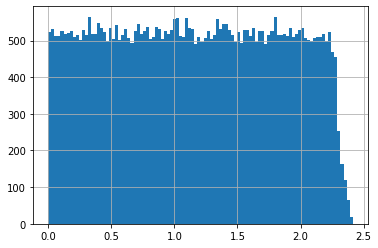

In [75]:
data['Ranking_global'].hist(bins=100)

Посмотрим распределение признака относительно конкретных оценок

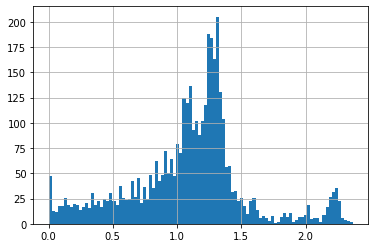

In [76]:
data['Ranking_global'][data['Rating'] == 5].hist(bins=100)

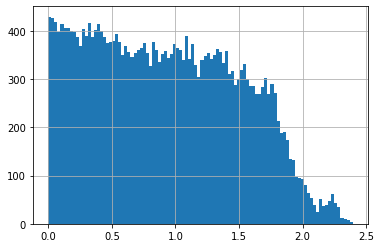

In [77]:
data['Ranking_global'][data['Rating'] >= 4].hist(bins=100)

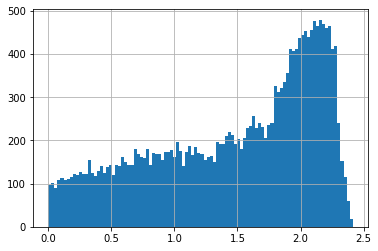

In [78]:
data['Ranking_global'][data['Rating'] < 4].hist(bins=100)

С большего распределение нормированного Ranking смещается в сторону оценки. Но интересная ситуация с ресторанами самого высокого рейтинга.  
Большинство ресторанов с высоким рейтингом не самые популярные в городе

Среднее кол-во отзывов о ресторане в городе
--

In [79]:
mean_number_reviews_in_city = data.groupby('City')['Number of Reviews'].mean()

In [80]:
data['mean_reviews'] = data['City'].apply(lambda x: mean_number_reviews_in_city[x])

Doble ID_TA
--

In [81]:
doble_id = data['ID_TA'].value_counts()

In [82]:
doble_id_l = doble_id[doble_id > 1].index

In [83]:
data['doble_id'] = data['ID_TA'].apply(lambda x: 1 if x in doble_id_l else 0)

Средний рейтинг по g_link
--

In [84]:
g_link_rating = data.groupby('g_link').median()['Rating']

In [85]:
data['rating_g_link'] = data['g_link'].apply(lambda x: g_link_rating[x])

## Проверим корреляцию

(20.0, 0.0)

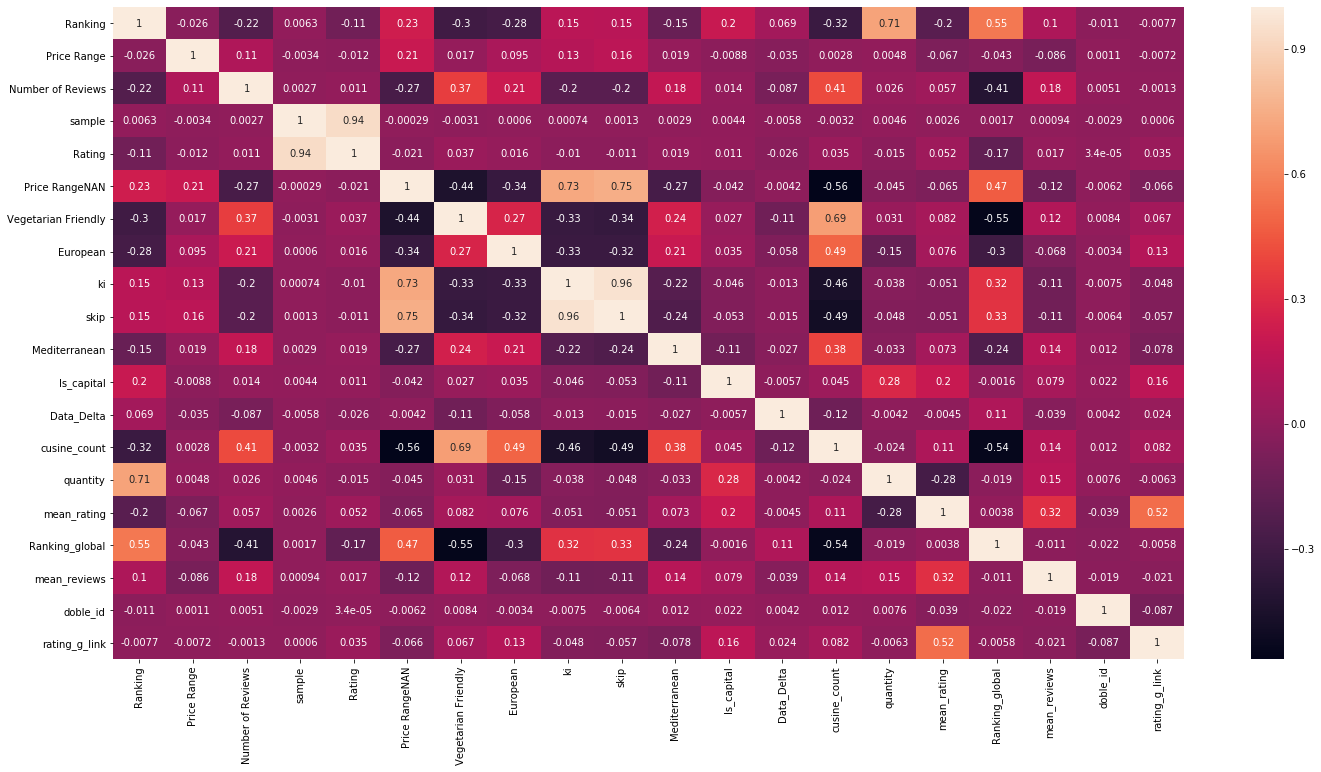

In [86]:
#df_temp = df.loc[df['Sample'] == 1, list(feat_importances.nlargest(15).index[0:15])]
plt.rcParams['figure.figsize'] = (24,12)
ax = sns.heatmap(data.corr(), annot=True, fmt='.2g')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

## Готовим датасет для ML

In [87]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
#df_output.drop(object_columns, axis = 1, inplace=True)

In [88]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)
X = X.drop(object_columns, axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [89]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [90]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 29), (40000, 29), (40000, 18), (32000, 18), (8000, 18))

# Model 
Сам ML

In [91]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [92]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [93]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20430874999999998


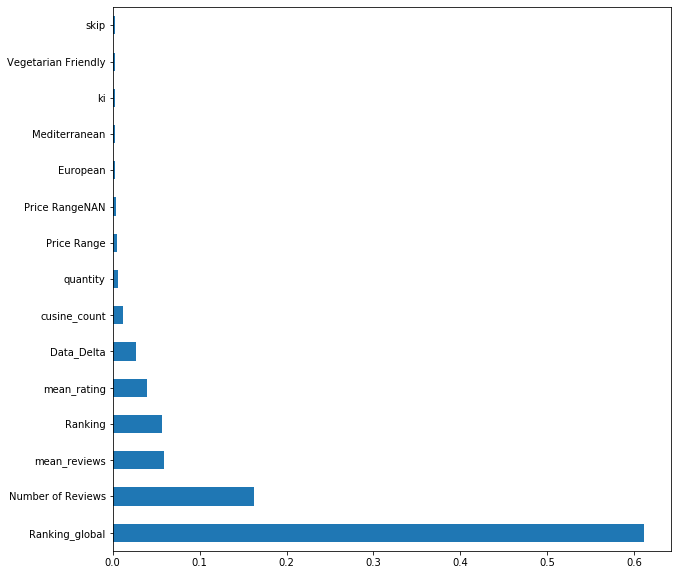

In [94]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
готовим Submission на кагл

In [95]:
test_data = test_data.drop(object_columns, axis=1)

In [96]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Price RangeNAN,Vegetarian Friendly,European,ki,skip,Mediterranean,Is_capital,Data_Delta,cusine_count,quantity,mean_rating,Ranking_global,mean_reviews,doble_id,rating_g_link
2510,53.0,3.0,233.0,0.0,0,1,1,0,0,0,1,26,3,1314,3.153349,0.040335,86.745053,0,4.0
458,2571.0,2.0,13.0,0.0,1,0,0,1,1,0,0,734,1,1145,3.156332,2.245415,71.971179,0,4.0
3770,2387.0,2.0,4.0,0.0,1,0,1,0,0,0,1,0,3,1314,3.153349,1.816591,86.745053,0,4.0
3172,994.0,2.0,66.0,0.0,0,0,1,0,0,0,1,181,5,1021,3.268854,0.973555,145.351616,0,4.0
8791,1889.0,2.0,1.0,0.0,1,0,1,0,0,0,1,0,3,1021,3.268854,1.850147,145.351616,0,4.0
8838,362.0,2.0,74.0,0.0,0,1,0,0,0,0,1,33,5,1816,3.204295,0.199339,110.104075,0,4.0
3958,3715.0,2.0,33.0,0.0,1,0,0,1,1,0,0,0,1,2694,3.028396,1.378990,160.118411,0,3.5
4069,4723.0,2.0,2.0,0.0,0,0,0,0,0,1,0,0,3,3395,3.189985,1.391163,126.506627,0,4.0
4591,1604.0,2.0,7.0,0.0,0,0,0,0,0,0,1,33,1,819,3.206960,1.958486,89.974359,0,4.0
9567,2168.0,2.0,237.0,0.0,0,1,0,0,0,0,1,10,4,6108,3.160773,0.354944,111.475933,0,4.0


In [97]:
test_data = test_data.drop(['Rating'], axis=1)

In [98]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [99]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [100]:
predict_submission

array([3.07 , 4.225, 4.485, ..., 3.065, 4.495, 4.16 ])

In [101]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.070
1,id_1,4.225
2,id_2,4.485
3,id_3,4.305
4,id_4,4.395
5,id_5,4.425
6,id_6,3.020
7,id_7,2.470
8,id_8,4.080
9,id_9,4.620
